<a href="https://colab.research.google.com/github/jhchang/Sentiment-Analysis-on-Arabic-Text/blob/main/arabic-dialect-code-switch-profiler/03_lightweight_deep_learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Lightweight Deep Learning Models

## 📚 Table of Contents
- Intro
- Preprocessing
- Model 1: CNN
- Model 2: BiLSTM
- Results & Analysis

#Intro

In this notebook, we experiment with lightweight deep learning architectures to improve dialect classification performance on Arabic social media text.

Having established strong classical baselines (MLP: 85%, SVM: 82%), our goal now is to leverage sequential modeling and local feature extraction using embeddings.

### ✅ Objectives:
- Convert raw Arabic text into padded token sequences.
- Train a **1D Convolutional Neural Network (CNN)** to capture local n-gram patterns.
- Train a **Bidirectional LSTM (BiLSTM)** to capture long-range contextual dependencies.
- Compare performance to previous models.


Here is a table for the mapping city Acronyms to the entire city names.


| **Country** | **City**   | **Code** |      | **Country**  | **City**  | **Code** |
| ----------- | ---------- | -------- | ---- | ------------ | --------- | -------- |
| Algeria     | Algiers    | ALG      |      | Palestine    | Jerusalem | JER      |
| Morocco     | Rabat      | RAB      |      | Syria        | Beirut    | BEI      |
|             | Fes        | FES      |      |              | Damascus  | DAM      |
| Tunisia     | Tunis      | TUN      |      |              | Aleppo    | ALE      |
|             | Sfax       | SFX      |      |              | Mosul     | MOS      |
| Libya       | Tripoli    | TRI      |      | Iraq         | Baghdad   | BAG      |
|             | Benghazi   | BEN      |      |              | Basra     | BAS      |
| Egypt       | Cairo      | CAI      |      | Saudi Arabia | Riyadh    | RIY      |
|             | Alexandria | ALX      |      |              | Jeddah    | JED      |
|             | Aswan      | ASW      |      | Oman         | Muscat    | MUS      |
| Sudan       | Khartoum   | KHA      |      | Qatar        | Doha      | DOHA     |
| Jordan      | Amman      | AMM      |      | Yemen        | Sanaa     | SAN      |
|             | Salt       | SAL      |      |              |           |          |


#Preprocessing

In [40]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import zipfile
from tqdm import tqdm
import os

zip_path = "/content/drive/MyDrive/datasets/MADAR-SHARED-TASK-final-release-25Jul2019.zip"
extract_to = "/content/MADAR/"

# Count the total number of files in the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    total_files = len(zip_ref.infolist())

    print(f"📦 Unzipping {total_files} files to {extract_to}...")

    with tqdm(total=total_files, unit="files") as pbar:
        for file in zip_ref.infolist():
            zip_ref.extract(member=file, path=extract_to)
            pbar.update(1)

print("✅ Unzip complete!")

📦 Unzipping 54 files to /content/MADAR/...


100%|██████████| 54/54 [00:00<00:00, 138.33files/s]

✅ Unzip complete!


In [42]:
import pandas as pd

# Replace with your file path
file_path = "/content/MADAR/MADAR-SHARED-TASK-final-release-25Jul2019/MADAR-Shared-Task-Subtask-1/MADAR-Corpus-26-train.tsv"
file_path2 = "/content/MADAR/MADAR-SHARED-TASK-final-release-25Jul2019/MADAR-Shared-Task-Subtask-1/MADAR-Corpus-26-dev.tsv"
file_path3 = "/content/MADAR/MADAR-SHARED-TASK-final-release-25Jul2019/MADAR-Shared-Task-Subtask-1/MADAR-Corpus-26-test.tsv"

# Read TSV file into a DataFrame
train_df = pd.read_csv(file_path, sep='\t', header=None, names=['text', 'dialect'])
val_df = pd.read_csv(file_path2, sep='\t', header=None, names=['text', 'dialect'])
test_df = pd.read_csv(file_path3, sep='\t', header=None, names=['text', 'dialect'])

In [43]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['label_id'] = le.fit_transform(train_df['dialect'])  # Integers
train_df['label_name'] = train_df['dialect']                  # Strings

# Save mapping if needed later
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

val_df['label_id'] = val_df['dialect'].replace(label_mapping)
val_df['label_name'] = val_df['dialect']

test_df['label_id'] = test_df['dialect'].replace(label_mapping)
test_df['label_name'] = test_df['dialect']

print(label_mapping)  # e.g., {'MSA': 0, 'RIY': 1, 'BEI': 2, ...}
# print(train_df['label_id'])
# print(val_df['label_id'])
# print(test_df['label_id'])

{'ALE': np.int64(0), 'ALG': np.int64(1), 'ALX': np.int64(2), 'AMM': np.int64(3), 'ASW': np.int64(4), 'BAG': np.int64(5), 'BAS': np.int64(6), 'BEI': np.int64(7), 'BEN': np.int64(8), 'CAI': np.int64(9), 'DAM': np.int64(10), 'DOH': np.int64(11), 'FES': np.int64(12), 'JED': np.int64(13), 'JER': np.int64(14), 'KHA': np.int64(15), 'MOS': np.int64(16), 'MSA': np.int64(17), 'MUS': np.int64(18), 'RAB': np.int64(19), 'RIY': np.int64(20), 'SAL': np.int64(21), 'SAN': np.int64(22), 'SFX': np.int64(23), 'TRI': np.int64(24), 'TUN': np.int64(25)}


<ipython-input-43-c4d556ed5027>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_df['label_id'] = val_df['dialect'].replace(label_mapping)
<ipython-input-43-c4d556ed5027>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['label_id'] = test_df['dialect'].replace(label_mapping)


In [44]:
X_train = train_df['text']
X_val = val_df['text']

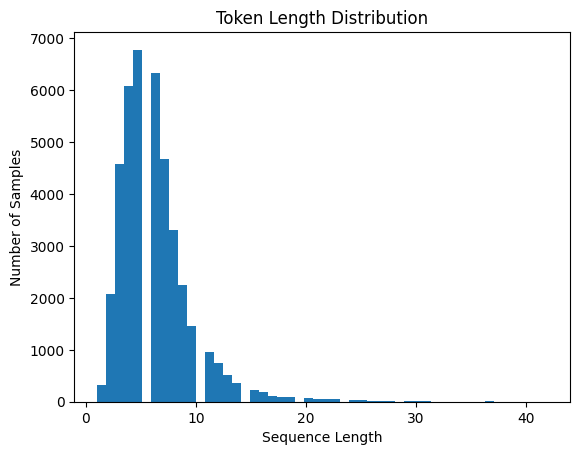

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Tokenize your text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

# Compute sequence lengths
sequence_lengths = [len(seq) for seq in sequences]

# Plot histogram
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Number of Samples')
plt.title('Token Length Distribution')
plt.show()


### Choosing an appropriate max_sequence_length is important because:

- Too short → truncates important info, hurting accuracy
- Too long → wastes memory and slows training, especially for RNNs

Setting the max sequence length to a certain percentile ensures most sequences are kept intact while reducing padding overhead.

🧠 Tips:

- CNNs tolerate fixed-length input well, so cutting off some long samples is fine.

- LSTMs are more sensitive to truncation, so you might allow longer sequences.

In [46]:
import numpy as np

print("95th percentile:", np.percentile(sequence_lengths, 98))
print("Max length in dataset:", max(sequence_lengths))


95th percentile: 16.0
Max length in dataset: 42


In [47]:
MAX_SEQUENCE_LENGTH = 16

---

### ✅ **1. Tokenizing Text**

```python
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
```

#### 🔍 What it does:

* Converts each sentence into a **list of integers**, where each integer corresponds to a word’s ID in the tokenizer’s vocabulary.

#### 🧠 Why it's needed:

* Neural networks **can’t process raw text**, so we must convert words into numerical form first.
* These sequences represent the **structure of sentences**, preserving word order.

#### Example:

```python
X_train = ["أنا أحب البرمجة"]
# Output: [[2, 45, 103]]   ← word IDs based on tokenizer's fitted vocabulary
```

---

### ✅ **2. Padding Sequences**

```python
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
```

#### 🔍 What it does:

* Ensures all sequences have the **same length**, by either:

  * **Truncating** longer ones (if they exceed `MAX_SEQUENCE_LENGTH`)
  * **Padding** shorter ones with 0s at the end (post-padding)

#### 🧠 Why it's needed:

* Neural networks expect inputs to be **uniform in shape** (e.g., tensors of shape `(batch_size, sequence_length)`).
* Padding ensures that every input has exactly `MAX_SEQUENCE_LENGTH` tokens.

#### Example:

If `MAX_SEQUENCE_LENGTH = 5`:

```python
[2, 45, 103]       → [2, 45, 103, 0, 0]   ← Padded with zeros
[9, 14, 8, 5, 3, 7] → [9, 14, 8, 5, 3]    ← Truncated to 5 tokens
```

---

### 🧠 Summary

| Step                 | Purpose                                      |
| -------------------- | -------------------------------------------- |
| `texts_to_sequences` | Convert text to list of word IDs             |
| `pad_sequences`      | Make all input sequences same length         |
| `padding='post'`     | Add zeros **after** the last token           |
| `maxlen=...`         | Define consistent input length for the model |

---


In [48]:
import pandas as pd
import re

# Load your dataset (adjust if needed)
# train_df = pd.read_csv("your_madar_file.csv")  # Uncomment if not loaded
sentences = train_df['text'].dropna().tolist()

# -------------------------------
# 1. Word-level (basic vocab size)
# -------------------------------
def simple_arabic_tokenize(text):
    return re.findall(r'\w+', text)

basic_vocab = set()
for sentence in sentences:
    tokens = simple_arabic_tokenize(sentence)
    basic_vocab.update(tokens)

print("✅ Basic word-level vocab size:", len(basic_vocab))


✅ Basic word-level vocab size: 27392


In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 16

# Tokenize
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


In [50]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
train_df['label_id'] = le.fit_transform(train_df['dialect'])  # Integers
train_df['label_name'] = train_df['dialect']                  # Strings

# Save mapping if needed later
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

val_df['label_id'] = val_df['dialect'].replace(label_mapping)
val_df['label_name'] = val_df['dialect']

test_df['label_id'] = test_df['dialect'].replace(label_mapping)
test_df['label_name'] = test_df['dialect']

print(label_mapping)  # e.g., {'MSA': 0, 'RIY': 1, 'BEI': 2, ...}
num_classes = len(le.classes_)
print(num_classes)
y_train = to_categorical(train_df['label_id'], num_classes=num_classes)
y_val = to_categorical(val_df['label_id'], num_classes=num_classes)

{'ALE': np.int64(0), 'ALG': np.int64(1), 'ALX': np.int64(2), 'AMM': np.int64(3), 'ASW': np.int64(4), 'BAG': np.int64(5), 'BAS': np.int64(6), 'BEI': np.int64(7), 'BEN': np.int64(8), 'CAI': np.int64(9), 'DAM': np.int64(10), 'DOH': np.int64(11), 'FES': np.int64(12), 'JED': np.int64(13), 'JER': np.int64(14), 'KHA': np.int64(15), 'MOS': np.int64(16), 'MSA': np.int64(17), 'MUS': np.int64(18), 'RAB': np.int64(19), 'RIY': np.int64(20), 'SAL': np.int64(21), 'SAN': np.int64(22), 'SFX': np.int64(23), 'TRI': np.int64(24), 'TUN': np.int64(25)}
26


<ipython-input-50-dc9c69f01720>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_df['label_id'] = val_df['dialect'].replace(label_mapping)
<ipython-input-50-dc9c69f01720>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['label_id'] = test_df['dialect'].replace(label_mapping)


# 📈 1D Convolutional Neural Network (CNN)

Convolutional Neural Networks are effective at extracting local features from sequences, particularly for capturing n-gram-like patterns in text. This makes them a strong baseline for short-text classification tasks.

In this section, we:
- Embed each token into a dense vector.
- Apply a 1D convolution with multiple filters.
- Use **GlobalMaxPooling** to retain the most salient features.
- Feed into dense layers for final classification.

CNNs are fast to train and parallelizable, making them ideal for edge applications.


---

### 🔍 Breakdown of Each Layer

#### 1. **Embedding Layer**

```python
Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128)
```

* Converts each word (by index) into a dense 128-dimensional vector.
* Learns word relationships during training.
* Input shape: `(batch_size, sequence_length)`
* Output shape: `(batch_size, sequence_length, 128)`

#### 2. **Conv1D Layer**

```python
Conv1D(filters=128, kernel_size=5, activation='relu')
```

* Applies 128 filters (like sliding windows) of size 5.
* Each filter learns to recognize specific word patterns (e.g., n-grams).
* Output shape: `(batch_size, new_sequence_length, 128)`

#### 3. **GlobalMaxPooling1D**

```python
GlobalMaxPooling1D()
```

* Picks the **maximum value** from each filter across the sequence.
* Reduces the output to shape: `(batch_size, 128)`
* Keeps the strongest signal for each learned feature.

#### 4. **Dense Layer**

```python
Dense(64, activation='relu')
```

* Fully connected layer to interpret pooled features.
* `64` neurons with ReLU activation.

#### 5. **Dropout Layer**

```python
Dropout(0.5)
```

* Randomly drops 50% of neurons during training.
* Helps prevent overfitting.

#### 6. **Output Layer**

```python
Dense(num_classes, activation='softmax')
```

* Outputs a probability distribution across `num_classes`.
* Final prediction is the class with the highest probability.

---

### 🧠 Summary

| Layer Type         | Purpose                                  |
| ------------------ | ---------------------------------------- |
| Embedding          | Learn word meanings                      |
| Conv1D             | Extract local features / n-gram patterns |
| GlobalMaxPooling1D | Reduce sequence into key features        |
| Dense              | Interpret features                       |
| Dropout            | Prevent overfitting                      |
| Dense (softmax)    | Output probability per class             |


---
🔍 Tokenization vs. Embedding: What's the Difference?

✅ Tokenization

- Converts raw text into integer sequences.

- Example: "أنا أحب اللغة العربية" → [23, 152, 8, 900]

- These integers are just IDs, not meaningful on their own.

✅ Embedding

- Maps those integer IDs into dense, learnable vectors.

- Example: 23 → [0.12, -0.88, ..., 0.54] (128 dimensions)

- These vectors capture semantic meaning of words (e.g., "أحب" and "أعشق" become similar).

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

cnn_model = Sequential([
    # 1️⃣ Embedding layer: maps word indices to dense vectors
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_shape=(MAX_SEQUENCE_LENGTH,)),
    # 2️⃣ 1D Convolution: slides over token embeddings to detect local patterns (like n-grams)
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    # 3️⃣ Global Max Pooling: selects the most important feature from each filter
    GlobalMaxPooling1D(),
    # 4️⃣ Fully connected layer: learns patterns from pooled features
    Dense(64, activation='relu'),
    # 5️⃣ Dropout: randomly sets some neurons to 0 during training to prevent overfitting
    Dropout(0.5),
    # 6️⃣ Output layer: softmax gives a probability for each class
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()

history = cnn_model.fit(X_train_pad, y_train, epochs=15, batch_size=64, validation_data=(X_val_pad, y_val))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 16, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 12, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,371,994 (5.23 MB)

 Trainable params: 1,371,994 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1159 - loss: 2.9998 - val_accuracy: 0.4490 - val_loss: 1.7182
Epoch 2/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4412 - loss: 1.6957 - val_accuracy: 0.5250 - val_loss: 1.4610
Epoch 3/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5525 - loss: 1.3306 - val_accuracy: 0.5392 - val_loss: 1.4278
Epoch 4/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6151 - loss: 1.1342 - val_accuracy: 0.5396 - val_loss: 1.4453
Epoch 5/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6640 - loss: 0.9870 - val_accuracy: 0.5429 - val_loss: 1.4811
Epoch 6/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6998 - loss: 0.8810 - val_accuracy: 0.5377 - val_loss: 1.5769
Epoch 7/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7288 - loss: 0.8156 - val_accuracy: 0.5438 - val_loss: 1.6480
Epoch 8/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7511 - loss: 0.7391 - val_accuracy: 0.

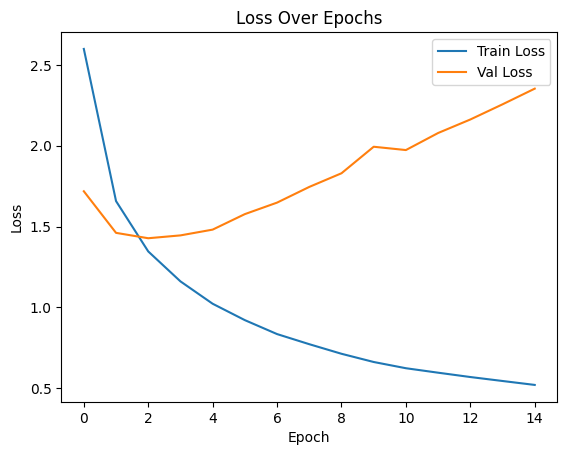

In [52]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

cnn_model2 = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_shape=(MAX_SEQUENCE_LENGTH,)),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])


cnn_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model2.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = cnn_model2.fit(X_train_pad, y_train, epochs=20, batch_size=64,
                        validation_data=(X_val_pad, y_val), callbacks=[early_stop])


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 16, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 12, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 4, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_5          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,392,794 (5.31 MB)

 Trainable params: 1,392,666 (5.31 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0559 - loss: 3.4966 - val_accuracy: 0.2938 - val_loss: 2.2975
Epoch 2/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2686 - loss: 2.3302 - val_accuracy: 0.3963 - val_loss: 1.8531
Epoch 3/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3687 - loss: 1.8957 - val_accuracy: 0.4396 - val_loss: 1.7390
Epoch 4/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4301 - loss: 1.6891 - val_accuracy: 0.4485 - val_loss: 1.7364
Epoch 5/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4764 - loss: 1.5426 - val_accuracy: 0.4683 - val_loss: 1.6705
Epoch 6/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5113 - loss: 1.4242 - val_accuracy: 0.4860 - val_loss: 1.6571
Epoch 7/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5441 - loss: 1.3315 - val_accuracy: 0.4883 - val_loss: 1.6571
Epoch 8/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5811 - loss: 1.2409 - val_accuracy: 0.

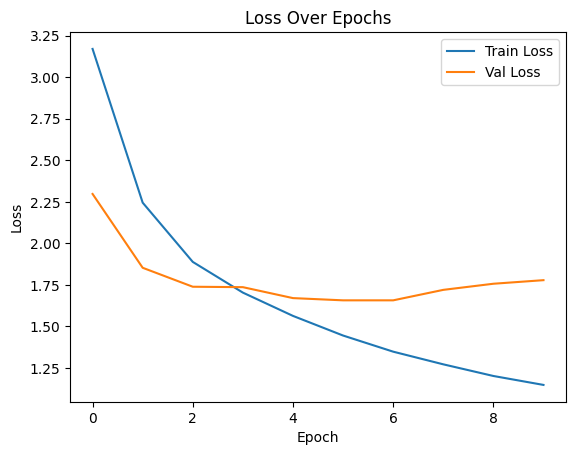

In [54]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# VOCAB SIZE?
A paper written by researchers at New York University Abu Dhabi and Carnegie Mellon University in Qatar found that Out of Vocabulary rates had a large influence on models tasked with data with multiple dialects in Arabic. They are also the engineers that designed the Arabic NLP model CAMeLBERT.

source: https://aclanthology.org/W19-4622.pdf

##💡 They discovered that data variant proximity is more important thatn pre-training data size. Let us test this theory out by increasing vocab size to the total number of unique words in our corpus. If the model shows more understanding to all the unique words it encounters in different dialects, will our model perform better?

In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
MAX_VOCAB_SIZE = 27392
MAX_SEQUENCE_LENGTH = 16

# Tokenize
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

cnn_model3 = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_shape=(MAX_SEQUENCE_LENGTH,)),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model3.summary()

history = cnn_model3.fit(X_train_pad, y_train, epochs=15, batch_size=64, validation_data=(X_val_pad, y_val))


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 16, 128)        │     3,506,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 12, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,598,170 (13.73 MB)

 Trainable params: 3,598,170 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.1179 - loss: 2.9882 - val_accuracy: 0.2927 - val_loss: 3.9961
Epoch 2/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4716 - loss: 1.5904 - val_accuracy: 0.3119 - val_loss: 6.8369
Epoch 3/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6137 - loss: 1.1412 - val_accuracy: 0.3208 - val_loss: 9.1192
Epoch 4/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7113 - loss: 0.8780 - val_accuracy: 0.3225 - val_loss: 11.4369
Epoch 5/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7587 - loss: 0.7352 - val_accuracy: 0.3212 - val_loss: 13.7633
Epoch 6/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7913 - loss: 0.6291 - val_accuracy: 0.3269 - val_loss: 13.5073
Epoch 7/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8165 - loss: 0.5593 - val_accuracy: 0.3258 - val_loss: 14.8851
Epoch 8/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8323 - loss: 0.5069 - val_accuracy

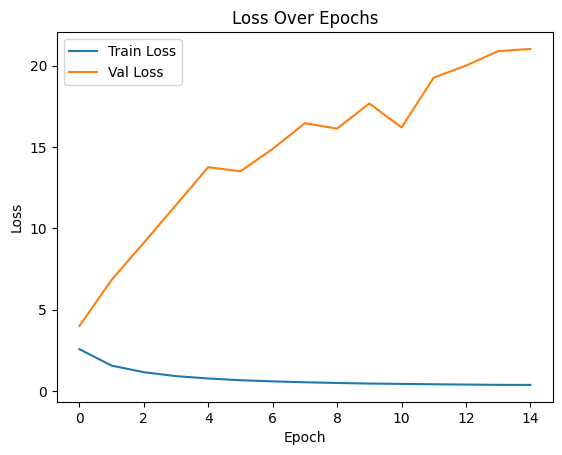

In [57]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

cnn_model4 = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_shape=(MAX_SEQUENCE_LENGTH,)),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])


cnn_model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model4.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = cnn_model4.fit(X_train_pad, y_train, epochs=20, batch_size=64,
                        validation_data=(X_val_pad, y_val), callbacks=[early_stop])


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 16, 128)        │     3,506,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 12, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 4, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_7          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,618,970 (13.81 MB)

 Trainable params: 3,618,842 (13.80 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.0643 - loss: 3.4607 - val_accuracy: 0.2083 - val_loss: 3.2538
Epoch 2/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3241 - loss: 2.1181 - val_accuracy: 0.2667 - val_loss: 4.2178
Epoch 3/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4812 - loss: 1.5678 - val_accuracy: 0.3146 - val_loss: 5.1730
Epoch 4/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5866 - loss: 1.2576 - val_accuracy: 0.3373 - val_loss: 4.7353


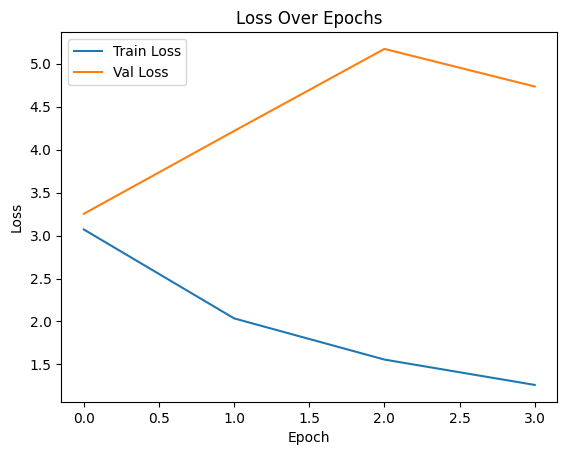

In [59]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# 📊 CNN Performance Summary

## Key Observations

1. **Training vs Validation Performance**:
   - Training accuracy reaches ~83% while validation accuracy plateaus around ~52-53%
   - This significant gap suggests overfitting - the model is memorizing the training data rather than learning generalizable patterns

2. **Loss Curves**:
   - Training loss continues to decrease while validation loss increases after a few epochs
   - This is another classic sign of overfitting

3. **Model Architecture**:
   - The CNN architecture is relatively simple (single Conv1D layer followed by dense layers)
   - May not be capturing the complexity needed for dialect classification

4. **Data Characteristics**:
   - We're working with 26 dialect classes, which is quite challenging
   - The dataset appears relatively small (650 batches per epoch)

## Potential Issues and Recommendations

### 1. Overfitting Problems

**Solutions**:
- Add more regularization:
  - Increase dropout rate (currently 0.5)
  - Add L2 regularization to dense layers
- Implement early stopping to prevent overtraining
- Use data augmentation (text augmentation is tricky but possible)

### 2. Model Architecture Improvements

**Suggestions**:
- Try deeper architectures:
  - Multiple Conv1D layers with pooling
  - Consider adding Batch Normalization
- Experiment with different kernel sizes in Conv layers
- Try bidirectional LSTMs or GRUs which often work well for text
- Consider pretrained embeddings instead of training from scratch


The key issue appears to be overfitting given the large gap between training and validation accuracy. The model is likely too complex for the amount of training data you have, or the data may not contain enough distinctive features for the model to properly differentiate between 26 dialects.

# 🔁 Bidirectional LSTM (BiLSTM)

Recurrent Neural Networks, specifically LSTMs, are designed to model sequential dependencies in text. A **Bidirectional LSTM** processes input in both forward and backward directions, enabling richer context understanding.

In this section, we:
- Embed sequences into vector space.
- Feed them into a BiLSTM layer to capture both past and future dependencies.
- Add dropout regularization and a dense softmax layer for classification.

BiLSTMs are more computationally intensive than CNNs, but excel at tasks where word order and context matter deeply—such as code-switching and dialect shifts.


In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 16

# Tokenize
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [61]:
from tensorflow.keras.layers import LSTM, Bidirectional

bilstm_model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_shape=(MAX_SEQUENCE_LENGTH,)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model.summary()

history = bilstm_model.fit(X_train_pad, y_train, epochs=15, batch_size=64, validation_data=(X_val_pad, y_val))


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 16, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,382,170 (5.27 MB)

 Trainable params: 1,382,170 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.1578 - loss: 2.8581 - val_accuracy: 0.4690 - val_loss: 1.6495
Epoch 2/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4909 - loss: 1.5060 - val_accuracy: 0.5406 - val_loss: 1.4159
Epoch 3/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6070 - loss: 1.1695 - val_accuracy: 0.5600 - val_loss: 1.3827
Epoch 4/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6644 - loss: 0.9961 - val_accuracy: 0.5665 - val_loss: 1.3833
Epoch 5/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7000 - loss: 0.8896 - val_accuracy: 0.5669 - val_loss: 1.3857
Epoch 6/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7253 - loss: 0.8053 - val_accuracy: 0.5650 - val_loss: 1.4334
Epoch 7/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7422 - loss: 0.7562 - val_accuracy: 0.5688 - val_loss: 1.4961
Epoch 8/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7564 - loss: 0.7086 - val_accuracy: 

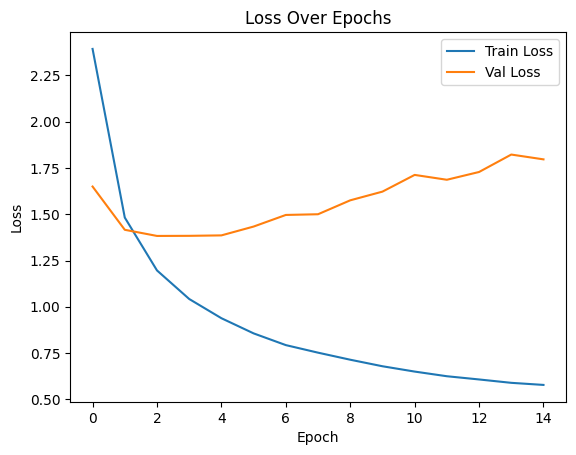

In [62]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [63]:
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.regularizers import l2

bilstm_model2 = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_shape=(MAX_SEQUENCE_LENGTH,)),
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

bilstm_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = bilstm_model2.fit(X_train_pad, y_train, epochs=15, batch_size=64,
                          validation_data=(X_val_pad, y_val), callbacks=[early_stop])

Epoch 1/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.0835 - loss: 3.7054 - val_accuracy: 0.2356 - val_loss: 2.3067
Epoch 2/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2600 - loss: 2.2006 - val_accuracy: 0.3158 - val_loss: 2.0362
Epoch 3/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3480 - loss: 1.8768 - val_accuracy: 0.3627 - val_loss: 1.9152
Epoch 4/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4059 - loss: 1.7097 - val_accuracy: 0.3958 - val_loss: 1.8307
Epoch 5/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4589 - loss: 1.5712 - val_accuracy: 0.4050 - val_loss: 1.8372
Epoch 6/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.4908 - loss: 1.4798 - val_accuracy: 0.4208 - val_loss: 1.7490
Epoch 7/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.5211 - loss: 1.3909 - val_accuracy: 0.4319 - val_loss: 1.7884
Epoch 8/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.5403 - loss: 1.3513 - val_a

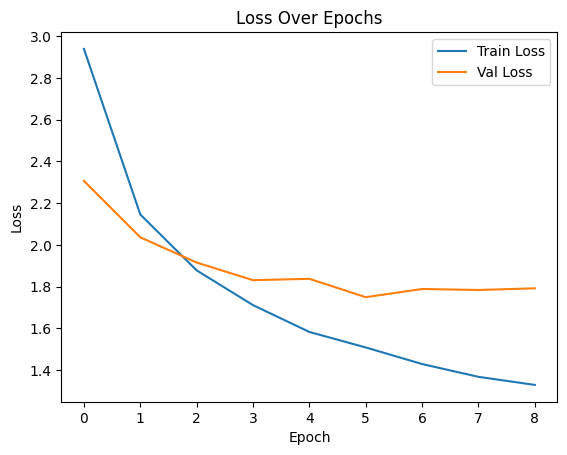

In [64]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
MAX_VOCAB_SIZE = 27392
MAX_SEQUENCE_LENGTH = 16

# Tokenize
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [66]:
from tensorflow.keras.layers import LSTM, Bidirectional

bilstm_model3 = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_shape=(MAX_SEQUENCE_LENGTH,)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

bilstm_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_model3.summary()

history = bilstm_model3.fit(X_train_pad, y_train, epochs=15, batch_size=64, validation_data=(X_val_pad, y_val))


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 16, 128)        │     3,506,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,608,346 (13.76 MB)

 Trainable params: 3,608,346 (13.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.1602 - loss: 2.8906 - val_accuracy: 0.3435 - val_loss: 2.6614
Epoch 2/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5234 - loss: 1.4133 - val_accuracy: 0.3733 - val_loss: 3.3145
Epoch 3/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6800 - loss: 0.9762 - val_accuracy: 0.3833 - val_loss: 3.9060
Epoch 4/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7582 - loss: 0.7474 - val_accuracy: 0.3935 - val_loss: 4.0563
Epoch 5/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8026 - loss: 0.6085 - val_accuracy: 0.3987 - val_loss: 4.3142
Epoch 6/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8211 - loss: 0.5433 - val_accuracy: 0.3946 - val_loss: 4.8094
Epoch 7/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8404 - loss: 0.4771 - val_accuracy: 0.3965 - val_loss: 4.9391
Epoch 8/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8469 - loss: 0.4507 - val_accuracy:

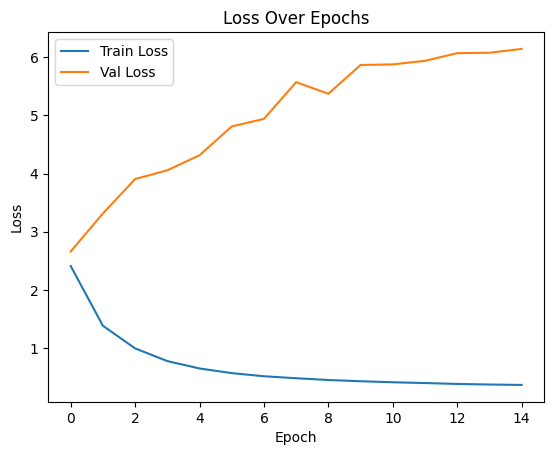

In [67]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [68]:
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.regularizers import l2

bilstm_model4 = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_shape=(MAX_SEQUENCE_LENGTH,)),
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01))),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

bilstm_model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = bilstm_model4.fit(X_train_pad, y_train, epochs=15, batch_size=64,
                          validation_data=(X_val_pad, y_val), callbacks=[early_stop])

Epoch 1/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.0700 - loss: 3.7650 - val_accuracy: 0.1952 - val_loss: 2.8246
Epoch 2/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.2792 - loss: 2.1212 - val_accuracy: 0.2258 - val_loss: 3.3894
Epoch 3/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4002 - loss: 1.6993 - val_accuracy: 0.2767 - val_loss: 3.2216
Epoch 4/15
650/650 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.4927 - loss: 1.4392 - val_accuracy: 0.2879 - val_loss: 3.7680


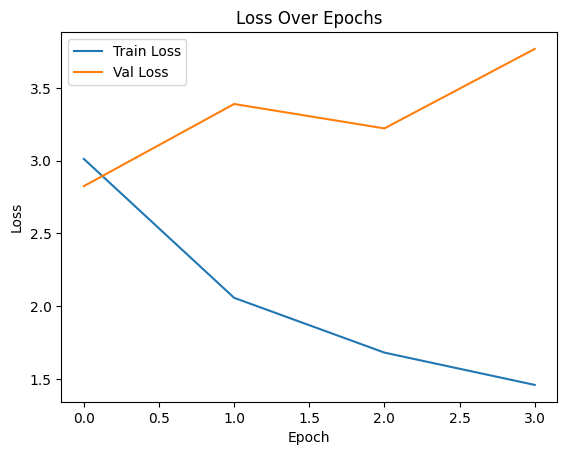

In [69]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [70]:
cnn_model.evaluate(X_val_pad, y_val)
cnn_model2.evaluate(X_val_pad, y_val)
cnn_model3.evaluate(X_val_pad, y_val)
cnn_model4.evaluate(X_val_pad, y_val)
bilstm_model.evaluate(X_val_pad, y_val)
bilstm_model2.evaluate(X_val_pad, y_val)
bilstm_model3.evaluate(X_val_pad, y_val)
bilstm_model4.evaluate(X_val_pad, y_val)


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5484 - loss: 2.9197
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5168 - loss: 1.7850
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3041 - loss: 25.1999
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1886 - loss: 3.3743
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5826 - loss: 1.7011
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5025 - loss: 1.6475
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3938 - loss: 6.4073
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2374 - loss: 2.8470


[2.8245816230773926, 0.19519230723381042]

# 📊 Final Results Summary

| Model Type       | Model Variant          | Accuracy  | Loss     | Best Performing Model | Description                                                                 |
|------------------|------------------------|-----------|----------|------|-----------------------------------------------------------------------------|
| CNN              | Baseline (`cnn_model`)  | 54.84%    | 2.9197   |      | Standard CNN model                                                          |
| CNN              | Enhanced (`cnn_model2`) | 51.68%    | 1.7850   |      | More layers + regularization                                               |
| CNN              | Full Vocab (`cnn_model3`)| 30.41%    | 25.1999  |      | Same as baseline but uses **MAX_VOCAB_SIZE** of entire training corpus     |
| CNN              | Full Vocab+ (`cnn_model4`)| 18.86%   | 3.3743   |      | Same as enhanced but uses **MAX_VOCAB_SIZE** of entire training corpus     |
| BiLSTM           | Baseline (`bilstm_model`)| 58.26%   | 1.7011   | ✓    | **Best model** (highest accuracy, lowest loss among BiLSTMs)               |
| BiLSTM           | Enhanced (`bilstm_model2`)| 50.25%  | 1.6475   |      | More layers + regularization                                               |
| BiLSTM           | Full Vocab (`bilstm_model3`)| 39.38% | 6.4073   |      | Same as baseline but uses **MAX_VOCAB_SIZE** of entire training corpus     |
| BiLSTM           | Full Vocab+ (`bilstm_model4`)| 23.74% | 2.8470   |      | Same as enhanced but uses **MAX_VOCAB_SIZE** of entire training corpus     |


⚠️ Note: Evaluation accuracy/loss may differ slightly from val_accuracy/val_loss during training due to dropout being disabled at inference time.

### **Summary of Model Performance Analysis**  

---

## **Overfitting But Regularizaiton Techniques Not Working**
- High training accuracy (80%+), but much lower validation accuracy (only ~55%)
- Validation loss worse than training loss and increasing over time.
- The original models are memorizing patterns in the training set and fail to generalize to new examples in the validation set.
- Increasing the vocabulary size did seems to greatly increase training accuracy, but validation loss diverged from training loss. The increase in the total words the model could learn from allowed the model to learn on the training set very well but could not generalize to the validation set.

###🤔 But Why Is This Happening?
Likely causes:

- Small sequences (16 tokens) may not contain enough signal for classification across 26 classes.

- No pretrained embeddings → the model has to learn everything from scratch.

Data causes:
- How clear are the dialects in each sample? Is each sample unique enough to be clearly distinguished as belonging to a certain dialect?

- Is it possible for a human to interperate a sample as being belonging to a different dialect than some other's intepretation?

- Is it possible to classify a sample as belonging to multiple dialects

For more information visit:

Paper: https://aclanthology.org/W19-4622.pdf

Website: https://sites.google.com/nyu.edu/madar/

---

#### **Possible Reasons for Performance Issues**  
- **Over-regularization**: Excess dropout or L2 penalties may have suppressed useful feature learning.  
- **Suboptimal Hyperparameters**: Learning rate, batch size, or layer sizes may not be tuned for the added complexity.  

---
## Most likely course of action
Since simple models seem too complex and adding regularization makes models perform too poorly. There seems to be a problem with overfitting with simple models and underfitting with simple models with regularization layers. I think we reached the limit of what hyperparameter tuning can do for us.

Many NLP models use **pre-trained embeddings** (GloVe, FastText) instead of learned embeddings. This allows models to leverage the weights/learnings of much larger, complex and powerful models and still being able to fine tune for specific needs. If we wanted to improve our model's performance we would likely need to use pretrained embeddings for arabic words.


## **Conclusion**  
While the augmented models were expected to improve performance, their increased complexity led to worse generalization. The original models, though simpler, were more effective for this task. Future work should focus on **controlled architecture scaling** and **systematic hyperparameter tuning** rather than arbitrary complexity increases. In the next notebook we will experiment with the most popular architectures for NLP, transformers.